### Classifying the Dogs in the Images

In [1]:
# Importing the packages
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import os
import json
import re
import cv2
from keras.utils.np_utils import to_categorical  
import h5py
import sys

Using TensorFlow backend.


In [2]:
tf.__version__

'1.1.0'

In [3]:
# defining different variables
data_dir = '../../data/dogs/Images/'

img_size = 299
flatten_img_size = img_size*img_size
img_shape = (img_size,img_size,3)
num_channels = 3
num_classes = 120

## Get all data

In [4]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(10,10))

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=2)
    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i], interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = label_cls_name_map[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = label_cls_name_map[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
# making the maps
label_cls_name_map = {}
label_name_cls_map = {}
label_cls=0

dirs = os.listdir(data_dir)
for dir_ in dirs:
    try:
        if '.DS_Store' in dir_:
            continue
        class_name = re.sub(r'n\d+-', '', dir_)
        label_cls_name_map[label_cls] = class_name
        label_name_cls_map[class_name] = label_cls
        label_cls+=1
    except Exception, err:
        print Exception, err
        


In [25]:
label_cls_name_json = json.dumps(label_cls_name_map, indent=4, separators=(',',':'))
with open('dogs_checkpoints/label_cls_name.json', 'w') as f:
    f.write(label_cls_name_json)

In [6]:
# Get all the images from the directory.
total_images = []
total_labels = []

label_cls = 0
for dir_ in dirs:
    try:
        if '.DS_Store' in dir_:
            continue
        for i,file_ in enumerate(os.listdir(os.path.join(data_dir, dir_))):
            full_file_path = os.path.join(os.path.join(data_dir,dir_),file_)
            img = cv2.imread(full_file_path)
            res_img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
            total_images.append(res_img)
            total_labels.append(label_cls)
        label_cls+=1
    except Exception, err:
        print Exception, err
        
# random shuffling
data = zip(total_images, total_labels)
np.random.shuffle(data)
total_images, total_labels = zip(*data)

total_images = np.array(total_images)
total_labels = np.array(total_labels)

print 'Data loaded successfully !!!'

Data loaded successfully !!!


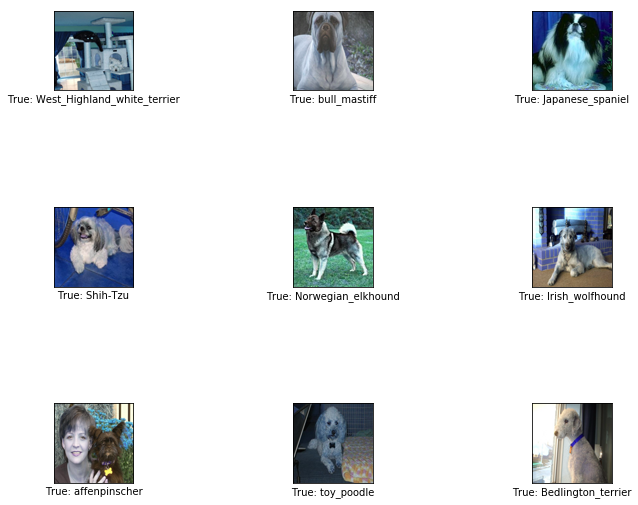

In [7]:
plot_images(total_images[:9,:], cls_true=total_labels[:9], smooth=True)

## Splitting the data into the training and the test set

In [8]:
# total_images has all images
# total_labels has all labels

num_classes = len(label_cls_name_map.values())
# one hot encoding
total_categorical_labels = to_categorical(total_labels, num_classes)

training_perc = 0.7
num_train_examples = int(len(total_images)*training_perc)
train_images, train_cls, train_labels = (total_images[:num_train_examples, :], 
                                         total_labels[:num_train_examples], 
                                         total_categorical_labels[:num_train_examples, :] )

test_images, test_cls, test_labels = (total_images[num_train_examples:,:], total_labels[num_train_examples:],
                                     total_categorical_labels[num_train_examples:, :])

# saving the data in form of h5
h5f = h5py.File('data.h5', 'w')
h5f.create_dataset('train_images', data=train_images)
h5f.create_dataset('train_labels', data=train_labels)
h5f.create_dataset('test_images', data=test_images)
h5f.create_dataset('test_labels', data=test_labels)
h5f.close()

In [ ]:
h5f = h5py.File('data.h5', 'r')
train_images = h5f['train_images'][:]
train_labels = h5f['train_labels'][:]
test_images = h5f['test_images'][:]
test_labels = h5f['test_labels'][:]
test_cls = np.argmax(test_labels,axis=1)
train_cls = np.argmax(train_labels, axis=1)
h5f.close()

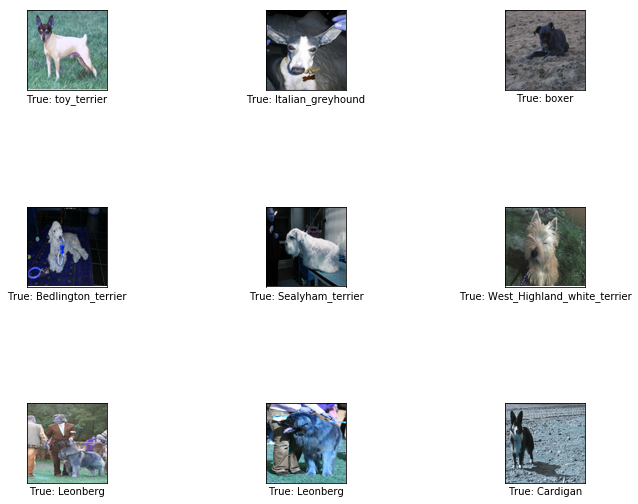

In [9]:
plot_images(test_images[:9,:], cls_true=test_cls[:9], smooth=True)

## tensorflow

In [10]:
def optimize(train_images, train_labels, epochs=1,train_batch_size=64):
    # Ensure we update the global variable rather than a local copy.
    for epoch_ in range(epochs):
        print 'Epoch: ', epoch_+1
        avg_acc = []
        for i in range(len(train_labels)/train_batch_size):
    
            # Get a batch of training examples.
            # x_batch now holds a batch of images and
            # y_true_batch are the true labels for those images.
            x_batch, y_true_batch = (train_images[i*train_batch_size : (i+1)*train_batch_size], 
                                     train_labels[i*train_batch_size : (i+1)*train_batch_size])

            # Put the batch into a dict with the proper names
            # for placeholder variables in the TensorFlow graph.
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}

            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            avg_acc.append(acc)
            # Print status every 100 iterations.
            if i % 10 == 0:
                # Message for printing.
                msg = "Optimization batch: {0:>6}, Training Accuracy: {1:>6.1%}"

                # Print it.
                print(msg.format(i + 1, acc))
        print 'Average accuracy for the Epoch: ', (float(sum(avg_acc))/len(avg_acc))*100

In [ ]:
# CNN MODEL

x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

conv1 = tf.layers.conv2d(inputs=x, name='layer_conv1', padding='same', filters=32, kernel_size=5, activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)
conv2 = tf.layers.conv2d(inputs=pool1, name='layer_conv2', padding='same', filters=64, kernel_size=5, activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)
layer3 = tf.contrib.layers.flatten(pool2)
fc1 = tf.layers.dense(inputs=layer3, name='layer_fc1', units=256, activation=tf.nn.relu)
net = tf.layers.dense(inputs=fc1, name='layer_fc_out', units=num_classes, activation=None)

logits = net
y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
loss = tf.reduce_mean(cross_entropy)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(loss)


session = tf.Session()
session.run(tf.global_variables_initializer())

optimize(train_images, train_labels,epochs=10, train_batch_size=64)

In [11]:
# INCEPTION MODEL

data_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"
inception_dir = '../../data/inception/'
path_uid_to_cls = "imagenet_2012_challenge_label_map_proto.pbtxt"
path_uid_to_name = "imagenet_synset_to_human_label_map.txt"
path_graph_def = "classify_image_graph_def.pb"

uid_cls = {}
cls_uid = {}
uid_name = {}

with open(os.path.join(inception_dir, path_uid_to_name), mode='r') as file:
    lines = file.readlines()
    for line in lines:
        line = line.replace("\n", "")
        elements = line.split("\t")
        uid = elements[0]
        name = elements[1]
        uid_name[uid] = name
        
with open(os.path.join(inception_dir, path_uid_to_cls), mode='r') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("  target_class: "):
            elements = line.split(": ")
            cls = int(elements[1])
        elif line.startswith("  target_class_string: "):
            elements = line.split(": ")
            uid = elements[1]
            uid = uid[1:-2]
            uid_cls[uid] = cls
            cls_uid[cls] = uid
            
tensor_name_input_jpeg = "DecodeJpeg/contents:0"
tensor_name_input_image = "DecodeJpeg:0"
tensor_name_resized_image = "ResizeBilinear:0"
tensor_name_softmax = "softmax:0"
tensor_name_softmax_logits = "softmax/logits:0"
tensor_name_transfer_layer = "pool_3:0"

graph = tf.Graph()
with graph.as_default():
    graph_path = path_graph_def
    with tf.gfile.FastGFile(os.path.join(inception_dir, graph_path), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

y_pred = graph.get_tensor_by_name(tensor_name_softmax)
y_pred_logits = graph.get_tensor_by_name(tensor_name_softmax_logits)
transfer_layer = graph.get_tensor_by_name(tensor_name_transfer_layer)
transfer_layer_len = transfer_layer.get_shape()[3]
resized_image = graph.get_tensor_by_name(tensor_name_resized_image)
session = tf.Session(graph=graph)

In [12]:
# INCEPTION TRANSFER LEARNING VALUES
transfer_values_train = []
i=0
for image_ in train_images:
    sys.stdout.write('\rProcessing train image: ' + str(i))
    feed_dict = {tensor_name_input_image: image_}
    transfer_values = np.squeeze(session.run(transfer_layer, feed_dict=feed_dict))
    transfer_values_train.append(transfer_values)
    i+=1
    
transfer_values_train = np.array(transfer_values_train)

# dumping the training transfer_values
h5f = h5py.File('transfer_values_train.h5', 'w')
h5f.create_dataset('values', data=transfer_values_train)
h5f.close()

transfer_values_test = []
i=0
for image_ in test_images:
    sys.stdout.write('\rProcessing test image: ' + str(i))
    feed_dict = {tensor_name_input_image: image_}
    transfer_values = np.squeeze(session.run(transfer_layer, feed_dict=feed_dict))
    transfer_values_test.append(transfer_values)
    i+=1
    
transfer_values = np.array(transfer_values_test)

# dumping the test transfer_values
h5f = h5py.File('transfer_values_test.h5', 'w')
h5f.create_dataset('values', data=transfer_values)
h5f.close()

Processing test image: 617404

In [9]:
# loading the trasnfer values from the cache
h5f = h5py.File('transfer_values_train.h5','r')
transfer_values_train = h5f['values'][:]
h5f.close()
h5f = h5py.File('transfer_values_test.h5','r')
transfer_values_test = h5f['values'][:]
h5f.close()

In [13]:
# TRANSFER LEARNING MODEL
x = tf.placeholder(tf.float32, shape=[None, transfer_layer_len], name='x')
fc1 = tf.layers.dense(inputs=x, name='layer_fc1', units=1024, activation=tf.nn.relu)
fc2 = tf.layers.dense(inputs=fc1, name='layer_fc2', units=512, activation=tf.nn.relu)
fc3 = tf.layers.dense(inputs=fc2, name='layer_fc3', units=256, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=fc3, name='layer_fc_out', units=num_classes, activation=None)

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
loss = tf.reduce_mean(cross_entropy)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(loss)

In [14]:
# TRANSFER LEARNING TRAINING
session = tf.Session()
session.run(tf.global_variables_initializer())

In [19]:
optimize(transfer_values_train, train_labels, epochs=20, train_batch_size=128)

Epoch:  1
Optimization batch:      1, Training Accuracy:  99.2%
Optimization batch:     11, Training Accuracy:  99.2%
Optimization batch:     21, Training Accuracy:  99.2%
Optimization batch:     31, Training Accuracy:  99.2%
Optimization batch:     41, Training Accuracy:  99.2%
Optimization batch:     51, Training Accuracy: 100.0%
Optimization batch:     61, Training Accuracy:  99.2%
Optimization batch:     71, Training Accuracy:  99.2%
Optimization batch:     81, Training Accuracy:  99.2%
Optimization batch:     91, Training Accuracy: 100.0%
Optimization batch:    101, Training Accuracy:  98.4%
Optimization batch:    111, Training Accuracy:  99.2%
Average accuracy for the Epoch:  99.3791852679
Epoch:  2
Optimization batch:      1, Training Accuracy: 100.0%
Optimization batch:     11, Training Accuracy: 100.0%
Optimization batch:     21, Training Accuracy:  99.2%
Optimization batch:     31, Training Accuracy:  99.2%
Optimization batch:     41, Training Accuracy:  99.2%
Optimization ba

In [22]:
saver = tf.train.Saver()
save_dir = 'dogs_checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
saver.save(sess=session, save_path=save_path)

'dogs_checkpoints/best_validation'

In [17]:
def predict(test_images, inception=False, transfer_layer=False):
    '''
    takes the list of np array of images as input and predicts the class.
    '''
    y_pred_list = []
    y_pred_cls_list = []
    for i,image_ in enumerate(test_images):
        shape_ = image_.shape
        if inception==True and transfer_layer==True:
            feed_dict = {x: transfer_values_test[i].reshape(1,-1)}
            y_pred_ = session.run(y_pred, feed_dict=feed_dict)
            y_pred_ = np.squeeze(y_pred_)
            y_pred_cls_ = np.argmax(y_pred_)
            y_pred_list.append(y_pred_cls_)
            y_pred_cls_list.append(y_pred_cls_)
            
        elif inception==True and transfer_layer==False:
            feed_dict = {tensor_name_input_image: image_}
            y_pred_ = session.run(y_pred, feed_dict=feed_dict)
            y_pred_ = np.squeeze(y_pred_)
            tmp_cls = np.argmax(y_pred_)
            tmp_name = uid_name[cls_uid[tmp_cls]].split(',')[0]
            tmp_name = re.sub(' ', '_', tmp_name)
            #print tmp_name
            try:
                y_pred_cls_ = label_name_cls_map[tmp_name]
            except:
                y_pred_cls_ = 0
            y_pred_list.append(y_pred_cls_)
            y_pred_cls_list.append(y_pred_cls_)
        else:
            feed_dict = {x: np.reshape(image_, (1, shape_[0], shape_[1], shape_[2]))}
            y_pred_ = session.run(y_pred, feed_dict=feed_dict)
            y_pred_ = np.squeeze(y_pred_)
            y_pred_cls_ = np.argmax(y_pred_)
            y_pred_list.append(y_pred_)
            y_pred_cls_list.append(y_pred_cls_)
    return np.array(y_pred_list), np.array(y_pred_cls_list)

In [24]:
test_pred, test_pred_cls = predict(test_images=test_images, inception=True, transfer_layer=True)

correct_prediction = (test_cls == test_pred_cls)
correct_sum = correct_prediction.sum()
acc = float(correct_sum) / len(test_cls)
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, len(test_cls)))

Accuracy on Test-Set: 77.6% (4790 / 6175)


In [ ]:
train_pred, train_pred_cls = predict(test_images=train_images, inception=True)
correct_prediction = (train_cls == train_pred_cls)
correct_sum = correct_prediction.sum()
acc = float(correct_sum) / len(train_cls)
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, len(train_cls)))